In [1]:
!pip install --upgrade -q pymc numpy openpyxl graphviz arviz jax jaxlib blackjax

/Users/ivanpetrov/.pyenv/versions/3.10.13/lib/python3.10/sre_parse.py:186: RuntimeWarning: coroutine 'Kernel.poll_control_queue' was never awaited
  i = min(i, l)
/Users/ivanpetrov/.pyenv/versions/3.10.13/lib/python3.10/sre_parse.py:186: RuntimeWarning: coroutine 'IPythonKernel.poll_stopped_queue' was never awaited
  i = min(i, l)


In [11]:
import pymc as pm
import pandas as pd
import numpy as np
import arviz as az
from copy import deepcopy

## Простенькая модель из одного параметра

Поможет разобраться, как самому писать модели

Из гайда: <br>
PyMC has three core functions that map to the traditional Bayesian workflow:

- pm.sample_prior_predictive (docs)
- pm.sample (docs)
- pm.sample_posterior_predictive (docs)
  
**Prior predictive** sampling helps understanding the relationship between the parameter priors and the outcome variable, before any data is observed.<br>

**Sampling** is used to infer the posterior distribution of parameters in a model, conditioned on observed data.<br>

**posterior predictive** sampling can be used to predict new outcomes, conditioned on the posterior parameters.<br>

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]
/Users/ivanpetrov/.pyenv/versions/3.10.13/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/Users/ivanpetrov/.pyenv/versions/3.10.13/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


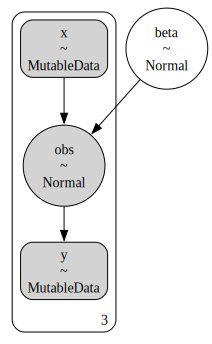

In [61]:
# Следуем гайду:
# https://www.pymc.io/projects/docs/en/v5.7.1/api/generated/pymc.set_data.html


with pm.Model() as model:

    # подкидываем данные в модель:
    x = pm.MutableData('x', [1., 2., 3.])
    y = pm.MutableData('y', [1., 2., 3.])

    # это неизвестный коэффициент
    beta = pm.Normal('beta', 0, 1)

    # задаём модель в явном виде
    obs = pm.Normal('obs', x * beta, 1, observed=y, shape=x.shape)

    # здесь идёт оценка модели через сэмплер
    # результаты оценки сэмплером будут сохранены в idata
    idata = pm.sample( return_inferencedata=True)


pm.model_to_graphviz(model)

In [62]:
# данные хранятся в объекте модели
model.x.get_value()

array([1., 2., 3.])

In [63]:
model.y.get_value()

array([1., 2., 3.])

In [64]:
# А вот результаты сэмплера лежат в idata
# отображаем оценку неизвестного коэффициента бета
az.summary(idata, var_names=["beta"])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,0.932,0.258,0.462,1.418,0.006,0.004,1713.0,2637.0,1.0


In [16]:
# Можно получить более детальную информацию об оценке коэффициента
# Оценку запустили четыре раза. Ниже распределение параметра в каждом запуске сэмплера
beta_distribution = idata.posterior.beta.values

print(beta_distribution)

print ("\n\n")
print ("Медианная оценка бета в каждом из 4 chains pymc")
print (beta_distribution.mean(axis=1))

[[0.99758422 1.45151134 1.13999594 ... 1.18393084 1.25066441 1.45911569]
 [0.72999144 0.85602288 0.85602288 ... 1.02332905 1.09791031 1.09791031]
 [1.36060909 0.83799859 0.9042521  ... 0.90888374 0.47101468 0.55761231]
 [0.5771623  0.65499294 1.01019332 ... 0.7675272  0.68193098 0.76652409]]



Медианная оценка бета в каждом из 4 chains pymc
[0.93262785 0.93516211 0.93985718 0.95509135]


In [76]:
# На скорость и точность оценки модели влияют три параметра draws, tune, chains
with pm.Model() as model:

    # подкидываем данные в модель:
    x = pm.MutableData('x', [1., 2., 3.])
    y = pm.MutableData('y', [2., 4., 6.])

    # это неизвестный коэффициент
    beta = pm.Normal('beta', 2, 1)

    # задаём модель в явном виде
    obs = pm.Normal('obs', x * beta, 1, observed=y, shape=x.shape)


    # здесь идёт оценка модели через сэмплер
    # на скорость оценки модели влияют три параметра draws, tune, chains
    # chains по дефолту равно числу ядер компьютера
    idata = pm.sample( return_inferencedata=True, draws = 25000, tune = 25000, chains = None)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]
/Users/ivanpetrov/.pyenv/versions/3.10.13/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/Users/ivanpetrov/.pyenv/versions/3.10.13/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Sampling 4 chains for 25_000 tune and 25_000 draw iterations (100_000 + 100_000 draws total) took 11 seconds.


In [77]:
az.summary(idata, var_names=["beta"])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,2.001,0.257,1.522,2.489,0.001,0.001,46146.0,70568.0,1.0


In [67]:
# На скорость и точность оценки модели влияют три параметра draws, tune, chains
# Так же можно поиграться с разными nuts_sampler - это может сильно ускорить оценку

with pm.Model() as model:

    # подкидываем данные в модель:
    x = pm.MutableData('x', [1., 2., 3.])
    y = pm.MutableData('y', [1., 2., 3.])

    # это неизвестный коэффициент
    beta = pm.Normal('beta', 0, 1)
 
    # задаём модель в явном виде
    obs = pm.Normal('obs', x * beta, 1, observed=y, shape=x.shape)


    # здесь идёт оценка модели через сэмплер
    # на скорость оценки модели влияют три параметра draws, tune, chains
    # chains по дефолту равно числу ядер компьютера
    idata = pm.sample( return_inferencedata=True, draws = 25000, tune = 25000, chains = None,  nuts_sampler='blackjax')

/Users/ivanpetrov/.pyenv/versions/3.10.13/envs/deep_env310/lib/python3.10/site-packages/pymc/sampling/jax.py:383: UserWarning: BlackJax currently only display progress bar correctly under `chain_method == 'vectorized'`. Setting `progressbar=False`.
  warnings.warn(


In [28]:
# делаем предсказание на трейне

# так как данные для Х и Y хранятся внутри класса "model", то при инференсе я бы делал копию модели
with deepcopy(model):
    idata_train = pm.sample_posterior_predictive(idata)

# результат:
idata_train.posterior_predictive['obs'].mean(('chain', 'draw')).values

Sampling: [obs]


array([0.92788605, 1.86161657, 2.79989615])

In [71]:
model.x.get_value()

array([1., 2., 3.])

In [73]:
# делаем предсказание на трейне
model2 = deepcopy(model)

# так как данные для Х и Y хранятся внутри класса "model", то при инференсе я бы делал копию модели
with model2:
    # здесь меняем параметры внутри модели
    pm.set_data({"x": [4,5,6]})
    idata_test = pm.sample_posterior_predictive(idata,)

# предсказания на трейн датасете
idata_test.posterior_predictive['obs'].mean(('chain', 'draw')).values

Sampling: [obs]


array([3.74179909, 4.67158053, 5.60491005])

## Попробуем предсказать инфляцию с помощью BVAR



In [78]:
# Идём по гайду:
# https://www.pymc.io/projects/examples/en/latest/time_series/bayesian_var_model.html

# Данные вот отсюда:
# https://github.com/european-central-bank/BEAR-toolbox/tree/master/tbx/replications

# BEAR
df = pd.read_excel("data_economic/data_.xlsx",index_col=0)

# проверяем, что в колонках только числовые переменные - '1974q1, ... ' - отправили в индекс
df

,DOM_GDP,DOM_CPI,STN,Oil
1974q1,-0.449406,7.383696,9.32,4.60
1974q2,0.354139,8.072929,11.25,15.50
1974q3,-1.542295,8.349771,12.09,13.00
1974q4,-1.113763,8.442405,9.35,11.50
1975q1,-2.588827,7.914478,6.30,11.70
...,...,...,...,...
2013q4,1.950169,0.842545,0.09,109.07
2014q1,1.437325,1.546078,0.07,110.50
2014q2,1.822617,1.514121,0.09,106.15
2014q3,1.930290,1.283037,0.09,110.89


In [97]:
### Define a helper function that will construct our autoregressive step for the marginal contribution of each lagged
### term in each of the respective time series equations
def calc_ar_step(lag_coefs, n_eqs, n_lags, df):
    # эта функция добавляет авторегрессионные лаги для каждой переменной
    ars = []
    for j in range(n_eqs):
        ar = pm.math.sum(
            [
                pm.math.sum(lag_coefs[j, i] * df.values[n_lags - (i + 1) : -(i + 1)], axis=-1)
                for i in range(n_lags)
            ],
            axis=0,
        )
        ars.append(ar)
    beta = pm.math.stack(ars, axis=-1)

    return beta


### Make the model in such a way that it can handle different specifications of the likelihood term
### and can be run for simple prior predictive checks. This latter functionality is important for debugging of
### shape handling issues. Building a VAR model involves quite a few moving parts and it is handy to
### inspect the shape implied in the prior predictive checks.
def make_model(n_lags, n_eqs, df, priors, n_train: int,  mv_norm=True, prior_checks=True):

    df = df.iloc[:n_train]
    
    coords = {
        "lags": np.arange(n_lags) + 1,
        "equations": df.columns.tolist(),
        "cross_vars": df.columns.tolist(),
        "time": [x for x in df.index[n_lags:]],
    }

    with pm.Model(coords=coords) as model:
        lag_coefs = pm.Normal(
            "lag_coefs",
            mu=priors["lag_coefs"]["mu"],
            sigma=priors["lag_coefs"]["sigma"],
            dims=["equations", "lags", "cross_vars"],
        )

        alpha = pm.Normal(
            "alpha", mu=priors["alpha"]["mu"], sigma=priors["alpha"]["sigma"], dims=("equations",)
        )

        data_obs = pm.Data("data_obs", 
                           df.iloc[n_lags:],  
                           mutable=True)


        betaX = calc_ar_step(lag_coefs, n_eqs, n_lags, df)
        betaX = pm.Deterministic(
            "betaX",
            betaX,
            dims=[
                "time",
            ],
        )

        mean = alpha + betaX

        if mv_norm:
            n = df.shape[1]
            ## Under the hood the LKJ prior will retain the correlation matrix too.
            noise_chol, _, _ = pm.LKJCholeskyCov(
                "noise_chol",
                eta=priors["noise_chol"]["eta"],
                n=n,
                sd_dist=pm.HalfNormal.dist(sigma=priors["noise_chol"]["sigma"]),
            )
            obs = pm.MvNormal(
                "obs", mu=mean, chol=noise_chol, observed=data_obs, dims=["time", "equations"]
            )
        else:
            ## This is an alternative likelihood that can recover sensible estimates of the coefficients
            ## But lacks the multivariate correlation between the timeseries.
            sigma = pm.HalfNormal("noise", sigma=priors["noise"]["sigma"], dims=["equations"])
            obs = pm.Normal(
                "obs", mu=mean, sigma=sigma, observed=data_obs, dims=["time", "equations"]
            )

        ## Здесь как раз рассчитываем саму модель
        ## на скорость оценки модели влияют три параметра draws, chains и tune
        idata = pm.sample(**priors['sampler_params'])      
        
    return model, idata


/Users/ivanpetrov/.pyenv/versions/3.10.13/envs/deep_env310/lib/python3.10/site-packages/pymc/sampling/jax.py:383: UserWarning: BlackJax currently only display progress bar correctly under `chain_method == 'vectorized'`. Setting `progressbar=False`.
  warnings.warn(
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


  lag_coefs: shape=(4, 2, 4)
      alpha: shape=(4,)
noise_chol_cholesky-cov-packed__: shape=(10,)
 noise_chol: shape=(10,)


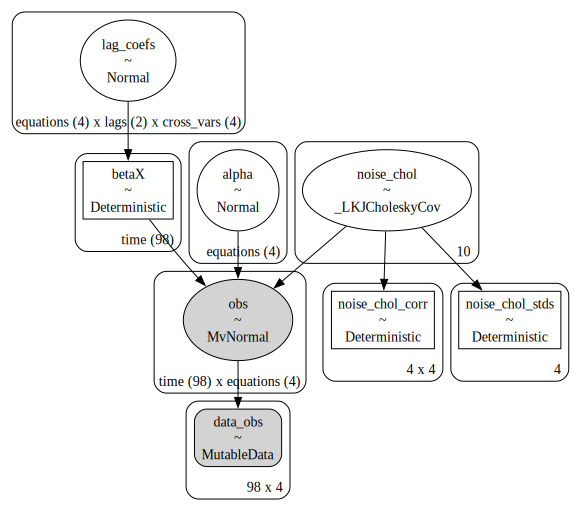

In [98]:
n_lags = 2
n_eqs = df.shape[1] #
priors = {
    "lag_coefs": {"mu": 0.3, "sigma": 1},
    "alpha": {"mu": 15, "sigma": 5},
    "noise_chol": {"eta": 1, "sigma": 1},
    "noise": {"sigma": 1},
    # 
    'sampler_params': {'chains': 2, 'draws': 200, 'tune': 200, 'nuts_sampler': 'blackjax'},
}



# функция оценит нашу модель
# и по скорости этой функции можно для себя оценить, как много времени нужно для тренировки баесовских моделей...
model, idata = make_model(n_lags, n_eqs, df, priors, n_train = 100)

# печатаем сколько параметров оценивали
for rv, shape in model.eval_rv_shapes().items():
    print(f"{rv:>11}: shape={shape}")

 
# требует установки graphviz
pm.model_to_graphviz(model)

In [99]:
# Здесь наша оценка коэффициентов модели
az.summary(idata, var_names=["alpha", "lag_coefs", "noise_chol_corr"])


/Users/ivanpetrov/.pyenv/versions/3.10.13/envs/deep_env310/lib/python3.10/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[DOM_GDP],1.560,0.391,0.951,2.429,0.017,0.012,525.0,261.0,1.01
alpha[DOM_CPI],0.412,0.185,0.059,0.706,0.008,0.006,497.0,366.0,1.00
alpha[STN],-0.269,0.426,-1.136,0.441,0.017,0.021,624.0,243.0,1.00
alpha[Oil],2.722,1.475,0.144,5.365,0.057,0.052,669.0,301.0,1.00
"lag_coefs[DOM_GDP, 1, DOM_GDP]",0.983,0.107,0.764,1.155,0.006,0.004,337.0,257.0,1.01
"lag_coefs[DOM_GDP, 1, DOM_CPI]",-0.259,0.197,-0.614,0.108,0.012,0.009,264.0,267.0,1.00
"lag_coefs[DOM_GDP, 1, STN]",0.062,0.098,-0.131,0.232,0.005,0.004,407.0,339.0,1.01
"lag_coefs[DOM_GDP, 1, Oil]",-0.019,0.027,-0.077,0.025,0.001,0.001,473.0,204.0,1.00
"lag_coefs[DOM_GDP, 2, DOM_GDP]",-0.316,0.094,-0.490,-0.146,0.004,0.003,517.0,221.0,1.02
"lag_coefs[DOM_GDP, 2, DOM_CPI]",0.210,0.202,-0.205,0.558,0.012,0.009,276.0,232.0,1.01


In [105]:
model.data_obs.get_value()

array([[-1.54229527,  8.34977125, 12.09      , 13.        ],
       [-1.11376263,  8.44240534,  9.35      , 11.5       ],
       [-2.58882748,  7.91447808,  6.3       , 11.7       ],
       [-0.85138677,  6.33696139,  5.42      , 11.5       ],
       [ 1.19495243,  5.2975816 ,  6.16      , 11.4       ],
       [ 3.74575625,  5.00877487,  5.41      , 11.5       ],
       [ 5.20954926,  4.95059838,  4.83      , 11.6       ],
       [ 4.3244909 ,  3.85589936,  5.2       , 12.9       ],
       [ 3.49808564,  3.61306697,  5.28      , 12.95      ],
       [ 2.00873653,  3.91748426,  4.87      , 13.15      ],
       [ 2.40840931,  4.84523834,  4.66      , 13.56      ],
       [ 3.84768919,  4.99252852,  5.16      , 14.45      ],
       [ 4.85542175,  4.92269408,  5.82      , 14.45      ],
       [ 3.71014663,  4.56750642,  6.51      , 14.28      ],
       [ 2.10844128,  4.54377781,  6.76      , 14.05      ],
       [ 4.1725601 ,  5.41821308,  7.28      , 13.95      ],
       [ 5.12999407,  6.

In [122]:
with pm.Model() as model:
    data_obs = pm.Data("data_obs2", 
                       df.iloc[n_lags:],  
                       mutable=True)
    
# data_obs.get_test_value().shape
type(data_obs)

pytensor.tensor.sharedvar.TensorSharedVariable

In [101]:
with deepcopy(model):
    pm.set_data({"data_obs", df.iloc[n_lags:].values})
    idata_train = pm.sample_posterior_predictive(idata, random_seed=44)



TypeError: unhashable type: 'numpy.ndarray'

<Axes: >

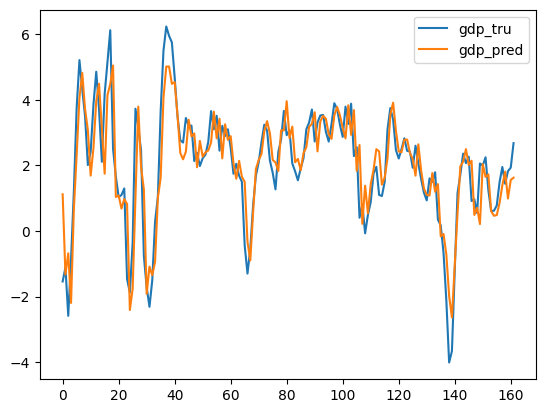

In [83]:
# Моделировали 4 переменных !
results = idata_train.posterior_predictive['obs'].mean(('chain', 'draw')).values

df_preds = pd.DataFrame({'gdp_tru': df['DOM_GDP'].values[n_lags:], # первые два наблюдения съели лаги
                         'gdp_pred': results[:,0] # первая перемення gdp
                        })

df_preds.plot()